In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [96]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [78]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Coding Dojo/Project/sales_predictions.csv')
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [79]:
# Set Item_Identifier as the index
df = df.set_index('Item_Identifier')

In [80]:
# Item_Weight and Outlet_Size are both missing data
# The data for both Item_weight and Outlet_Size can be dropped.
df.drop(columns = 'Item_Weight', inplace = True)
df.drop(columns = 'Outlet_Size', inplace = True)

In [81]:
# Check for any duplicate rows
df.duplicated().any()

False

In [82]:
# Check for spelling errors or inconsistencies
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [83]:
# There are inconsistencies with the spelling of low fat and regular so fix that
df.loc[df['Item_Fat_Content'] == 'LF', 'Item_Fat_Content'] = 'Low Fat'
df.loc[df['Item_Fat_Content'] == 'reg', 'Item_Fat_Content'] = 'Regular'
df.loc[df['Item_Fat_Content'] == 'low fat', 'Item_Fat_Content'] = 'Low Fat'
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [10]:
# Check for inconsistencies with the spelling of item types
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [11]:
# Check for inconsistencies with outlet location type
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [12]:
# Check for inconsistencies with outlet type
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [23]:
# Check for any more missing data
df.isnull().sum()

Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [ ]:
# Check for any outliers using z-scores
from scipy import stats

z = np.abs(stats.zscore(df['Item_Visibility']))
print(np.where(z > 3))

(array([  49,   83,  108,  174,  434,  502,  521,  532,  854, 1159, 1272,
       1291, 1311, 1324, 1434, 1496, 1501, 1560, 1575, 1644, 1651, 1805,
       1827, 1841, 2088, 2122, 2251, 2324, 2439, 2445, 2586, 2613, 2728,
       2855, 2895, 3017, 3206, 3399, 3458, 3474, 3488, 3497, 3540, 3750,
       3767, 3884, 3993, 4006, 4219, 4382, 4408, 4530, 4656, 4674, 4789,
       4941, 5031, 5150, 5287, 5374, 5732, 5734, 5795, 5837, 5880, 5891,
       5946, 6008, 6012, 6179, 6536, 6576, 6622, 6674, 6786, 6903, 7005,
       7088, 7107, 7121, 7215, 7250, 7278, 7388, 7499, 7558, 7603, 7744,
       7866, 7949, 8194, 8215, 8273, 8345, 8432]),)


In [ ]:
z = np.abs(stats.zscore(df['Item_MRP']))
print(np.where(z > 3))

(array([], dtype=int64),)


In [ ]:
z = np.abs(stats.zscore(df['Item_Outlet_Sales']))
print(np.where(z > 3))

(array([ 130,  145,  276,  304,  333,  373,  456,  472,  661,  694,  753,
        809,  935,  991,  997, 1009, 1138, 1254, 1450, 1506, 1859, 1998,
       2109, 2216, 2238, 2293, 2516, 2535, 2776, 3083, 3087, 3098, 3154,
       3234, 3286, 3407, 3667, 3709, 3720, 3757, 4289, 4346, 4349, 4676,
       4681, 4772, 4888, 4961, 4991, 5065, 5177, 5185, 5223, 5315, 5500,
       5550, 5619, 5752, 5799, 5812, 5977, 6000, 6134, 6334, 6409, 6537,
       6541, 6606, 6886, 6993, 7016, 7076, 7188, 7191, 7236, 7256, 7302,
       7343, 7560, 7562, 7609, 7690, 7752, 7816, 7826, 7930, 8039, 8201,
       8245, 8447]),)


In [ ]:
# Filters
low_fat = df['Item_Fat_Content'] == 'Low Fat'
regular = df['Item_Fat_Content'] == 'Regular'

# Dataframes of the filters
df_lf = df[low_fat]
df_reg = df[regular]

# Change column name
df_lf = df_lf.rename(columns = {'Item_Fat_Content' : 'Low Fat'})
df_reg = df_reg.rename(columns = {'Item_Fat_Content' : 'Regular'})

# Count number of low fat and regular for each item type
lf_gb = df_lf.groupby(['Item_Type'])[['Low Fat']].count()
reg_gb = df_reg.groupby(['Item_Type'])[['Regular']].count()

In [ ]:
# Concatenate new dataframe
c = pd.concat([lf_gb, reg_gb], axis = 1)
c.drop(index = ['Hard Drinks', 'Health and Hygiene', 'Household', 'Others'], inplace = True)
c = c.sort_values('Low Fat')
c

,Low Fat,Regular
Seafood,37,27.0
Breakfast,41,69.0
Starchy Foods,82,66.0
Breads,140,111.0
Meat,170,255.0
Baking Goods,329,319.0
Canned,341,308.0
Soft Drinks,374,71.0
Dairy,418,264.0
Frozen Foods,450,406.0


''

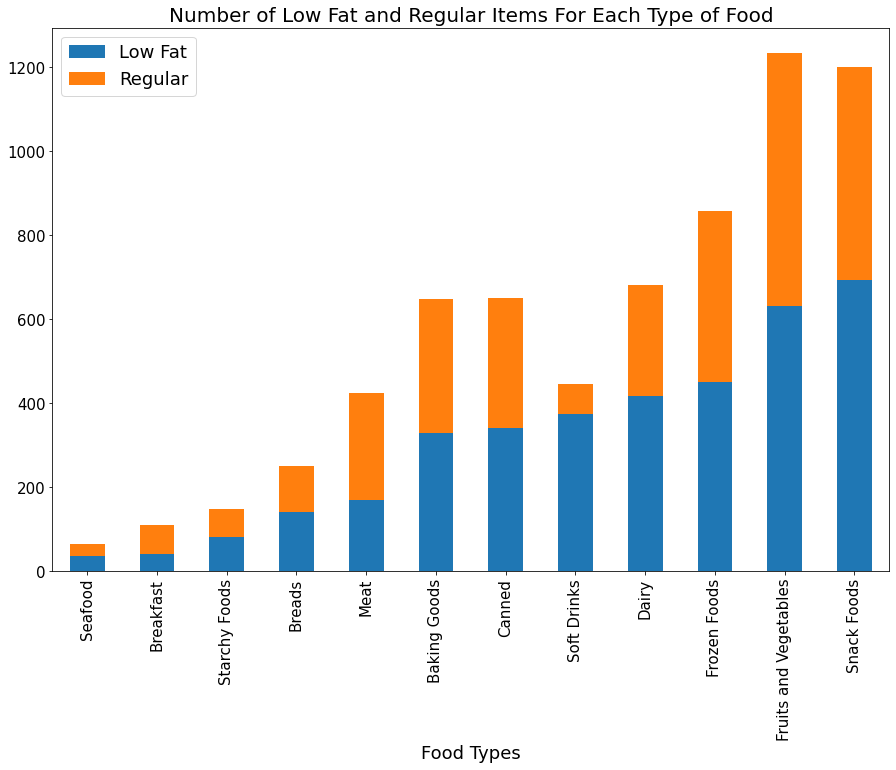

In [ ]:
# Create a stacked bar chart for number of low fat and regular items for each item type
c.plot(kind = 'bar', stacked = True, figsize = (15,10))

# Set labels, title, legend and font size
plt.xlabel('Food Types', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Number of Low Fat and Regular Items For Each Type of Food', fontsize = 20)
plt.legend(loc = 2, fontsize = 18)
;

''

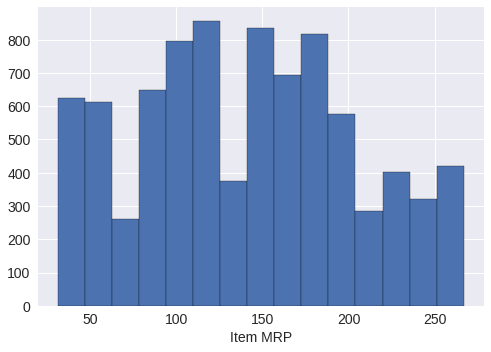

In [ ]:
# Histogram of Item MRP
df['Item_MRP'].hist(bins = 15, edgecolor = 'black')
plt.style.use('seaborn')

plt.xlabel('Item MRP', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
;

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


''

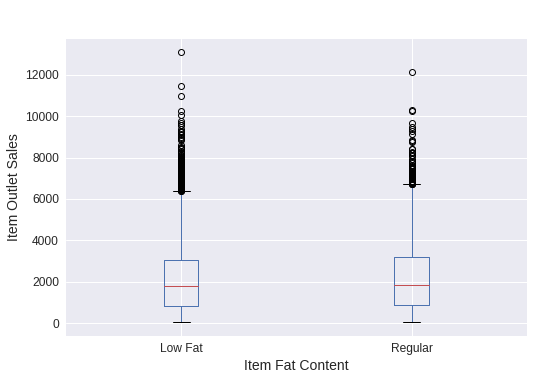

In [ ]:
# Boxplot
df.boxplot(column = 'Item_Outlet_Sales', by = 'Item_Fat_Content')

plt.title(' ')
plt.suptitle(' ')
plt.xlabel('Item Fat Content', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylabel('Item Outlet Sales', fontsize = 14)
plt.yticks(fontsize = 12)
;

In [85]:
# Map the replacement dictionary
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].map({1985: 0, 1987: 1, 1997: 2, 1998: 3, 1999: 4, 2002: 5, 2004: 6, 2007: 7, 2009: 8})

In [86]:
df.head()

,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,
FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,4,Tier 1,Supermarket Type1,3735.1380
DRC01,Regular,0.019278,Soft Drinks,48.2692,OUT018,8,Tier 3,Supermarket Type2,443.4228
FDN15,Low Fat,0.016760,Meat,141.6180,OUT049,4,Tier 1,Supermarket Type1,2097.2700
FDX07,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,3,Tier 3,Grocery Store,732.3800
NCD19,Low Fat,0.000000,Household,53.8614,OUT013,1,Tier 3,Supermarket Type1,994.7052


In [87]:
# One-hot encode nominal categorical variables
ohe = pd.get_dummies(df, columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type'], drop_first = True)

In [88]:
ohe.head()

,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
Item_Identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FDA15,0.016047,249.8092,4,3735.1380,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
DRC01,0.019278,48.2692,8,443.4228,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
FDN15,0.016760,141.6180,4,2097.2700,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
FDX07,0.000000,182.0950,3,732.3800,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
NCD19,0.000000,53.8614,1,994.7052,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0


In [94]:
# Arrange data into features matrix and target vector
x = ohe[['Item_Visibility',
        'Item_MRP',
        'Outlet_Establishment_Year',
        'Item_Fat_Content_Regular',
        'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods', 'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
        'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
        'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3']]
y = ohe['Item_Outlet_Sales']

In [105]:
# Standardize data, fit on x, and transform x
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x);

In [106]:
# KNN regressor
knn = KNeighborsRegressor()
knn.fit(x, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [107]:
# Predict sales
pred = knn.predict(x)

In [108]:
# R^2 score
knn.score(x, y)

0.6661945323749678